# Introductory applied machine learning (INFR10069)

# Assignment 2: Linear regression

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

Fill out this notebook, save it, and **submit it electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw1 05_Assignment_2.ipynb`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename=05_Assignment_2.ipynb
local_scp_filepath=~/git/iaml2017/${filename}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath} ${UUN}@${server_address}:${filename}
# rsync -rl ${local_scp_filepath} ${UUN}@${server_address}:${filename}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw1 05_Assignment_2.ipynb
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

Execute the cell below to import all packages you will be using in the rest of the assignemnt.

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
%matplotlib inline

## Description of the dataset
This assignment is based on the automobile pricing dataset. Our goal will be to predict the price of automobiles based on various attributes. This data set consists of three types of entities: 

1. The specification of an automobile in terms of various characteristics 

1. Assigned insurance risk rating 
   * this rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuaries call this process ”symboling”. A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe. 

1. Normalized losses in use as compared to other cars
  * the third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year (avg_loss/car/year). 


To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We removed any instances that had one or more missing values and randomized the data set. The resulting representation is much more compact and can be used directly to perform our experiments.


## 1. Simple Linear Regression [50%]
We will begin by studying a simple Linear Regression model. Such a model will consider the relationship between a dependent (response) variable and only one independent (explanatory) variable. When applying machine learning in practice it can be prudent to start out simple in order to get a feeling for the dataset and for any potential difficulties that might warrant a more sophisticated model. In this Section we will consider one independent variable (i.e. feature) `engine-power` against the dependent variable (i.e. target) `price`.

### ========== Question 1.1 --- [1 mark] ==========
Load the dataset `train_auto_numeric.csv` into a pandas DataFrame called `auto_numeric`. Display the number of data points and attributes in the dataset.

In [2]:
loc = os.path.join(os.getcwd(),'datasets','train_auto_numeric.csv')
auto_numeric = pd.read_csv(loc)
print("The number of data points is {} and the number of attributes is {}".format(auto_numeric.shape[0],
                                                                                  auto_numeric.shape[1]))

The number of data points is 159 and the number of attributes is 16


### ========== Question 1.2 --- [1 mark] ==========
Display the first 8 instances of the dataset.

In [3]:
auto_numeric.head(8)

,normalized-losses,wheel-base,length,width,height,engine-size,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,mean-effective-pressure,torque,price
0,164.0,99.8,176.6,66.2,54.3,8.85,3.19,3.40,10.0,102000.0,5500.0,24.0,30.0,40.52,57.68,13950.0
1,110.0,99.4,162.4,66.4,54.3,15.18,3.19,3.40,8.0,115000.0,5500.0,18.0,22.0,47.39,59.59,17450.0
2,158.0,105.8,192.7,71.4,51.6,15.18,3.94,2.80,8.5,70000.0,4400.0,28.0,30.0,0.85,3344.79,17710.0
3,106.0,86.6,158.7,67.7,55.9,13.74,3.13,3.50,7.8,140000.0,5600.0,32.0,20.0,44.74,68.97,23875.0
4,192.0,101.2,176.8,64.8,54.3,8.67,3.50,2.80,8.8,101000.0,5800.0,23.0,29.0,44.78,53.48,16430.0
5,194.0,110.0,190.9,71.4,58.7,8.67,3.78,3.90,22.5,101000.0,6000.0,47.0,53.0,1.80,1330.28,16925.0
6,188.0,101.2,176.8,64.8,54.3,26.58,3.31,3.19,9.0,121000.0,4250.0,21.0,28.0,7.19,377.06,20970.0
7,150.0,101.2,176.8,64.8,56.1,26.58,3.03,3.19,8.0,134000.0,4400.0,28.0,37.0,57.37,48.20,21105.0


### ========== Question 1.3 --- [1 mark] ==========
Display the summary statistics for the dataset.

In [4]:
auto_numeric.describe()

,normalized-losses,wheel-base,length,width,height,engine-size,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,mean-effective-pressure,torque,price
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,121.955975,98.559748,171.698113,65.729560,53.925157,14.056352,3.294528,3.219874,10.446855,98528.301887,5072.012579,27.113208,32.327044,46.180503,200.055031,11684.723270
std,39.434186,5.803361,12.656791,2.292021,2.410446,17.143568,0.296959,0.381833,4.414796,34123.715967,549.988239,7.848229,8.231998,28.780966,513.289289,6744.910579
min,65.000000,86.600000,141.100000,60.300000,49.400000,3.390000,2.540000,2.070000,7.000000,48000.000000,4150.000000,15.000000,18.000000,0.490000,19.400000,5118.000000
25%,93.000000,94.500000,163.400000,64.000000,52.000000,6.960000,3.050000,3.070000,8.600000,69000.000000,4800.000000,22.000000,26.500000,21.775000,34.140000,7372.000000
50%,110.000000,97.000000,171.700000,65.400000,54.100000,9.030000,3.270000,3.270000,9.000000,92000.000000,5100.000000,26.000000,32.000000,49.800000,55.900000,9233.000000
75%,145.000000,101.200000,177.800000,66.500000,55.600000,14.885000,3.580000,3.410000,9.400000,116000.000000,5450.000000,31.000000,37.000000,68.495000,119.990000,14719.500000
max,256.000000,115.600000,202.600000,71.700000,59.800000,174.160000,3.940000,4.170000,23.000000,200000.000000,6600.000000,49.000000,54.000000,99.850000,3912.870000,42056.000000


### ========== Question 1.4 --- [2 marks] ==========
Produce a scatter plot of `price` against `engine-power`. Label axes appropriately and include a title in your plot.

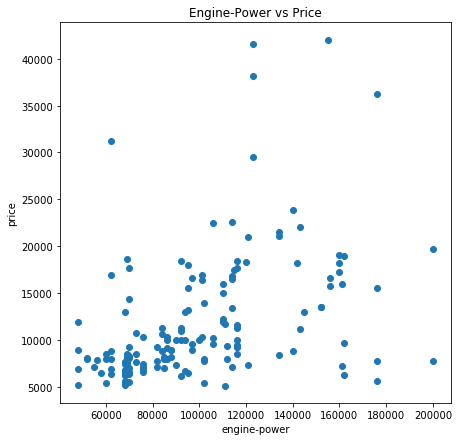

In [5]:
plt.figure(figsize=(7,7))
plt.scatter(auto_numeric['engine-power'],auto_numeric['price'])
plt.xlabel('engine-power')
plt.ylabel('price')
plt.title('Engine-Power vs Price')
plt.show()

### ========== Question 1.5 --- [2 marks] ==========
Do you think that engine-power alone is sufficient for predicting the price? Can you make any other observations on the data from the above plot? Please explain your answer in 2-3 sentences. 


Engine-power can be used to predict the price to some extent because there seems to be a positive correlation. But there are instances where even low engine-powered autos are expensive and vice-versa. Clearly there are other factors in play.

It can be observed that most cars have engine power around or lower than 120,000 and most cars cost around and less than 15,000.

### ========== Question 1.6 --- [2 marks] ==========
Visualise the distribution of the car prices. Choose a sensible value for the number of bins in the histogram. Again, label axes appropriately and include a title in your plot.

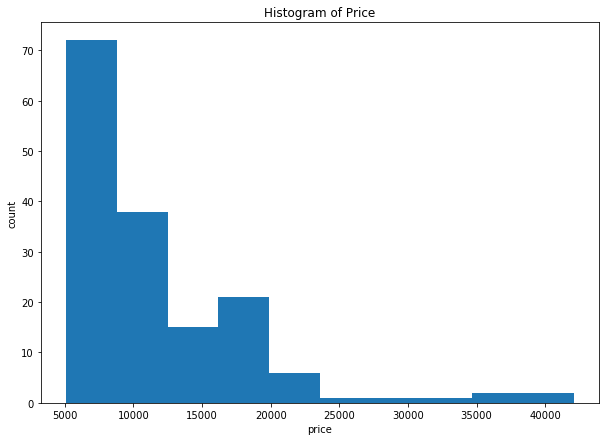

In [6]:
plt.figure(figsize=(10,7))
plt.hist(auto_numeric['price'])
plt.xlabel('price')
plt.ylabel('count')
plt.title('Histogram of Price')
plt.show()

### ========== Question 1.7 --- [2 marks] ==========
How could you preprocess the data to improve the performance of linear regression? Don’t do it at this stage, but instead in one sentence explain why you would do what you suggested.


Linear regression is extremely sensitive to outliers. For a better performance, we can remove records with values more than threshold descibed in answer to question 1.5 or we can transform the data. Some trial and error will be required to understand which is the best course of action. This should be fine since majority values lie below the threshhold. (We can get a more accurate threshold if needed) 

### ========== Question 1.8 --- [1 mark] ==========
Now we want to build a simple linear regression model. First we need to define our input and target variables. Store the values of the attribute `engine-power` in a vector `X` and the values of our target variable `price` in a vector `y`.

In [7]:
X, y = auto_numeric['engine-power'].as_matrix(), auto_numeric['price'].as_matrix()

### ========== Question 1.9 --- [1 mark] ==========
For technical reasons, we need to convert `X` into a 2D array, otherwise we will receive an error when trying to use it for building models. Perform this transformation and confirm that the shape of the resulting array is (`n`,1) where `n` is the number of instances in the dataset. 

In [8]:
X = X.reshape(159,1)

In [9]:
print("The shape of X is {}".format(X.shape))

The shape of X is (159, 1)


### ========== Question 1.10 --- [1 mark] ==========
Now we want to use Hold-out validation to split the dataset into training and testing subsets. Use 80% of the data for training and the remaining 20% for testing. Store your data into matrices `X_train`, `X_test`, `y_train`, `y_test`.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=0)

### ========== Question 1.11 --- [2 marks] ==========
By using Scikit-learn's [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) fit a model to the training data. When initialising the model, set the `normalize` parameter to `True` and use default settings for the other parameters.

In [11]:
lr = LinearRegression(normalize=True)
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

### ========== Question 1.12 --- [2 marks] ==========
By looking into the attributes of your model, write down an equation for predicting the price of a car given the engine-power.

In [12]:
print("The price of the car, y = x * {} + {}, where x is the engine power.".format(lr.coef_[0],lr.intercept_))

The price of the car, y = x * 0.0898838874387 + 2823.1218911, where x is the engine power.


### ========== Question 1.13 --- [3 marks] ==========
What happens to the price as one more unit of engine-power is added? By examining the magnitude of the regression coefficient is it possible to tell whether or not engine-power is an important influential variable on price? Explain your answer in 1-2 sentences.

If n units are added, we have, 

In [13]:
print("y = (x+n) * {0} + {1} = x * {0} + n * {0} + {1} ".format(lr.coef_[0],lr.intercept_))

y = (x+n) * 0.0898838874387 + 2823.1218911 = x * 0.0898838874387 + n * 0.0898838874387 + 2823.1218911 


With addition of every unit, the price increases by the value of the coefficient. The coefficient is basically the average increase in price when engine-power increases by one unit.

It is reasonable to tell whether or not an attribute is an influential variable based on the regression coefficient for it ONLY IF we have a way to compare these coefficients. Generally this is not possible. We can't compare mass and length, or torque and price. Furthermore, each of these may use different units, for example, Kg & g, and m and km. One solution to this could be checking how much does the mean value of an attribute change the output in comparison to the mean value of other attribures.

We only know that a higher coefficient means the variable is given more weight. Here, since other coefficients are unknown and are unavailbale for comparison, the coefficient does not help at all.

### ========== Question 1.14 --- [2 marks] ==========
Produce a scatter plot similar to the one in Question 1.4 but use training data only this time. Add the regression line to the plot and show the predictions on the training set by using a different marker. Label axes appropriately and add a title to the graph. 

In [14]:
def plot_regression_line():  
    x = np.array(range(200000))  
    y = x * 0.0898838874387 + 2823.1218911
    plt.plot(x, y)  

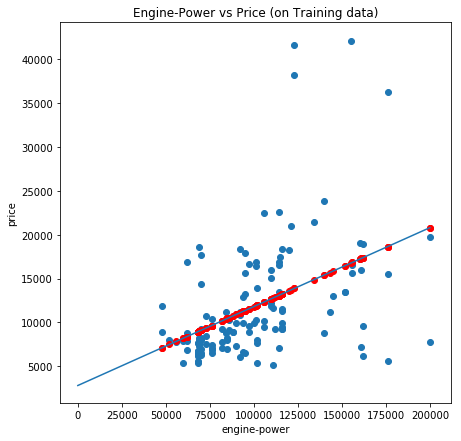

In [15]:
plt.figure(figsize=(7,7))

plot_regression_line()

plt.scatter(X_train,y_train)
plt.scatter(X_train, lr.predict(X_train), color='r')

plt.xlabel('engine-power')
plt.ylabel('price')
plt.title('Engine-Power vs Price (on Training data)')
plt.show()

### ========== Question 1.15 --- [2 marks] ==========
So far we have used Hold-out validation. Can you think of a disadvantage of using this method, especially when dealing with small datasets?

The classes are not balanced when diving the data using Hold-Out validation. This can be a huge disadvantage with small datasets.

### ========== Question 1.16 --- [1 mark] ==========
Now we want to use k-fold cross-validation to evaluate the performance of the regression model. Famliriase yourself with the sklearn method [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) and make sure you understand the differences between Hold-out and K-fold cross-validation. By using Scikit-learn's [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class construct a 5-fold cross-validation object. Set the `shuffle` parameter to `True` and `random_state` to `0`. Use the object to print the training and validation indices for the `auto_numeric` dataset (hint: see the `split` method).

In [16]:
kf = KFold(n_splits=5,shuffle=True,random_state=0)
i = 0
for train_index, test_index in kf.split(auto_numeric):
    i = i + 1
    print("Fold {}\n".format(i))
    print("Train:\n {}\nTest:\n {}".format(train_index, test_index))
    print("\n\n")

Fold 1

Train:
 [  0   1   2   3   4   5   6   9  10  11  12  13  14  15  16  17  18  20
  21  22  23  25  27  28  29  30  31  32  34  35  36  38  39  41  42  43
  46  47  48  49  50  51  52  53  55  57  58  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  84  87  88  89  91  92
  93  94  96  97  98  99 100 101 102 103 104 105 106 107 108 109 111 112
 113 114 115 116 117 118 121 122 123 124 125 127 129 130 132 133 135 136
 137 138 139 140 141 143 145 146 147 149 150 151 152 153 154 155 156 157
 158]
Test:
 [  7   8  19  24  26  33  37  40  44  45  54  56  59  60  61  62  63  83
  85  86  90  95 110 119 120 126 128 131 134 142 144 148]



Fold 2

Train:
 [  0   1   3   4   5   6   7   8   9  11  12  13  14  15  17  19  20  21
  23  24  25  26  28  29  31  32  33  34  35  36  37  38  39  40  41  42
  44  45  46  47  48  49  50  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  67  68  69  70  72  75  76  77  78  79  81  82  83  84  85
  86  87  88  90  

### ========== Question 1.17 --- [3 marks] ==========
By making use of the iterator you constructed in the previous question, loop through the 5 folds and display the mean value of the `price` variable for the training instances in each fold.

In [17]:
fold = 0
for train_indices, test_indices in kf.split(auto_numeric):
    price = []
    fold = fold + 1
    for index in train_indices:
        price.append(auto_numeric.iloc[index]['price'])
    print("The mean value of price for fold {} is {}".format(fold,np.mean(price)))
    

The mean value of price for fold 1 is 11853.2677165
The mean value of price for fold 2 is 11635.976378
The mean value of price for fold 3 is 11689.8740157
The mean value of price for fold 4 is 11709.8267717
The mean value of price for fold 5 is 11535.84375


### ========== Question 1.18 --- [3 marks] ==========
Now initialise a new `LinearRegression` model and fit it by making use of the cross-validation iterator, the `X` and `y` arrays defined above and the [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) function. Display the shape of your prediction and confirm it has the same dimensionality as your `y` vector.

In [18]:
lr2 = LinearRegression()
predicted = cross_val_predict(lr2,X,y,cv=kf)
print("The shape of predicted is {} and the shape of y is {}.".format(predicted.shape,y.shape))

The shape of predicted is (159,) and the shape of y is (159,).


### ========== Question 1.19 --- [2 marks] ==========
Report the Coefficient of Determination (R^2), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and Correlation Coefficient (CC) from the simple linear regression model you build in Question 1.18. *Hint: RMSE is the square root of the Mean Squared Error (MSE). For CC you might find numpy's [`corrcoef`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html) function useful.* 

In [19]:
r2 = r2_score(y, predicted)
rmse = np.sqrt(mean_squared_error(y, predicted))
mae = mean_absolute_error(y, predicted) 
coeff = np.corrcoef(y,predicted)[0,1]
print("r2: {}\tRMSE: {}\tMAE: {}\tCC: {}".format(r2, rmse, mae, coeff))

r2: 0.173005270976	RMSE: 6114.45211862	MAE: 3987.95779619	CC: 0.417122199043


### ========== Question 1.20 --- [4 marks] ==========
What do the above metrics intend to measure? Relate the values of CC, MAE and RMSE to the observations you made in Question 1.5. Explain your answer in 1-2 short paragraphs.

In Q1.5, I observed some correlation but more infomation was needed for decent performance. 

This is evident with the error values above. First observation is that we are matching the trends in true values to some extent. This is evident by slight positive correlation coefficient. RMSE and MAE reassert that we need more information to get a better prediction.

### ========== Question 1.21 --- [3 marks] ==========
Show a histogram of the residuals of the linear regression model (i.e. true - predicted values). Label axes appropriately and add a title to your plot. Does the distribution of residuals look like what you expected?

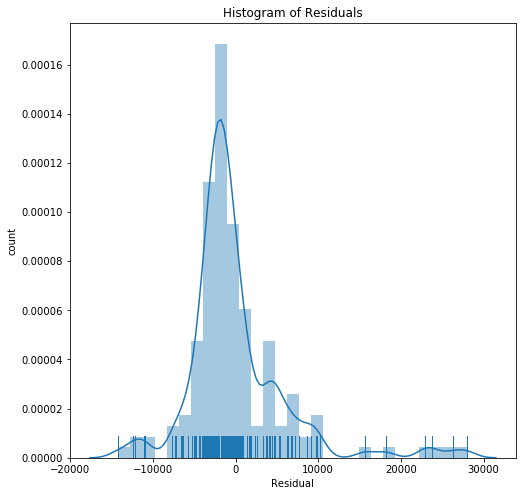

In [20]:
plt.figure(figsize=(8,8))
sns.distplot(y - predicted,rug=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("count")
plt.show()

I was expecting a gaussian distribution in the errors with not a good bell shape for the graph since the errors seem significant. The graph does resemble a normal distribution somewhat. 


### ========== Question 1.22 --- [2 marks] ==========
Load the new dataset `train_auto_base.csv` into a pandas DataFrame `auto_base`. Again by using the `engine-power` attribute as predictor and `price` as target variable build a LinearRegression model on this dataset. Report the R^2, RMSE, MAE and CC metrics for this model by making use of the K-fold CV iterator constructed in Question 1.16.

In [21]:
loc2 = os.path.join(os.getcwd(),'datasets','train_auto_base.csv')
auto_base = pd.read_csv(loc2)


linReg = LinearRegression()
predicted2 = cross_val_predict(linReg,auto_base['engine-power'].values.reshape(159,1),auto_base['price'],cv=kf)

r2 = r2_score(auto_base['price'], predicted2)
rmse = np.sqrt(mean_squared_error(auto_base['price'], predicted2))
mae = mean_absolute_error(auto_base['price'], predicted2) 
coeff = np.corrcoef(auto_base['price'],predicted2)[0,1]
print("r2: {}\tRMSE: {}\tMAE: {}\tCC: {}".format(r2, rmse, mae, coeff))

r2: -0.00213595381121	RMSE: 6730.84360395	MAE: 4901.86096203	CC: -0.0619144160589


### ========== Question 1.23 --- [2 marks] ==========
Show a scatter plot of predicted vs. true prices and another one of predicted price vs. engine-power. Use a single plot with two subplots. Label axes appropriately.

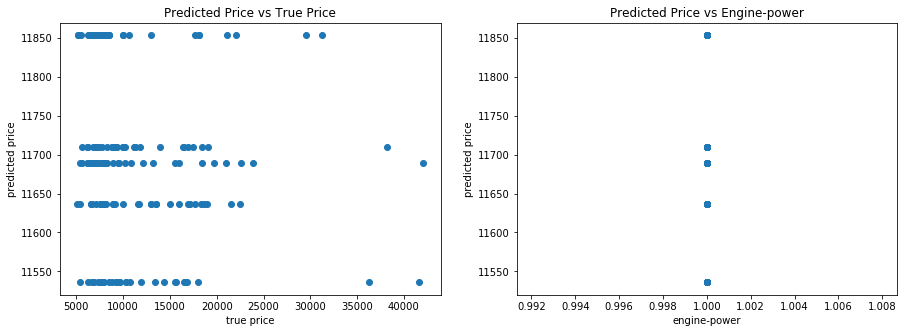

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.scatter(auto_base['price'],predicted2)
ax1.set_ylabel('predicted price')
ax1.set_xlabel('true price')
ax1.set_title('Predicted Price vs True Price')

ax2.scatter(auto_base['engine-power'],predicted2)
ax2.set_ylabel('predicted price')
ax2.set_xlabel('engine-power')
ax2.set_title('Predicted Price vs Engine-power')

plt.show()

### ========== Question 1.24 --- [3 marks] ==========
What is the simplest baseline model for the purposes of regression? Relate your answer to the regression model you have just built as part of this question. Can the predictions of this model be justified given the procedure you followed to train it?

The simplest baseline model for regression would be when the data points for training are irrelevant and only the mean,median of the target data is given as output always. 

Above, from the scatter plot, we have set all data points (engine-power) to be same (equal to 1) and have trained our model. On checking, auto_base['price'] = auto_numeric['price']. 

So we are actually trying to make a baseline model that predicts based only on the distribution of values of price.

This can be justified as a way to come up with our baseline predictor because it models the distribution of the output variable.

### ========== Question 1.25 --- [2 marks] ==========
Why do you think this model performs so poorly? (*Hint: Justify your answer by displaying some statistics about the `auto_base` dataset.*)

In [23]:
auto_base.describe()

,engine-power,price
count,159.0,159.000000
mean,1.0,11684.723270
std,0.0,6744.910579
min,1.0,5118.000000
25%,1.0,7372.000000
50%,1.0,9233.000000
75%,1.0,14719.500000
max,1.0,42056.000000


This model performs poorly simply because no extra information other than price itself is available as engine-power is always 1.

## 2. Multivariate Linear Regression [50%]
In this Section we will fit a Multivariate Linear Regression model (LinearRegression) to the dataset. In contrast to Part 1, we will now train a model with multiple explanatory variables and ascertain how they affect our ability to predict the retail price of a car. One of our foremost concerns will be to determine exactly which attributes to include in the model and which may be left out.

### ========== Question 2.1 --- [10 marks] ==========
Use the original dataset (`auto_numeric`) and a visualisation tool of your choice to examine whether or not any of the other attributes are particularly good at predicting the price. Can you find any? Do any attributes appear useless at predicting the price? Do any attributes exhibit significant correlations? As you answer these questions, list two attributes for each question but do not modify the dataset at this stage. Of the attributes you listed, which ones could you safely remove? Explain in 4-5 sentences. *Hint: you might find seaborn's [`pairplot`](https://seaborn.github.io/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) function useful for this question.*

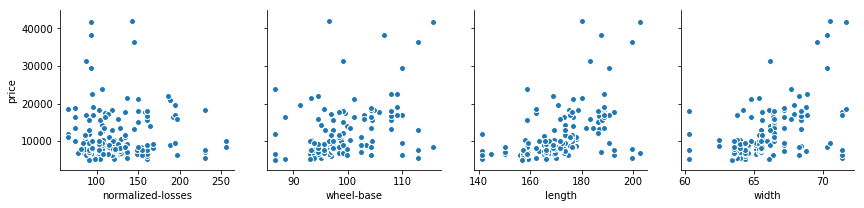

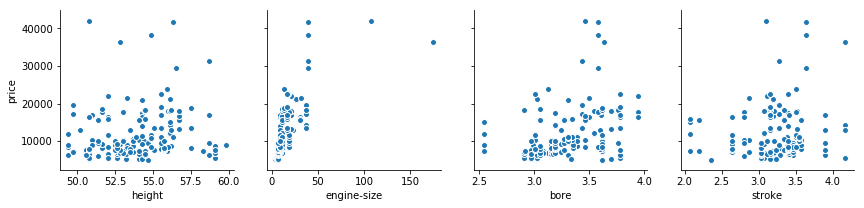

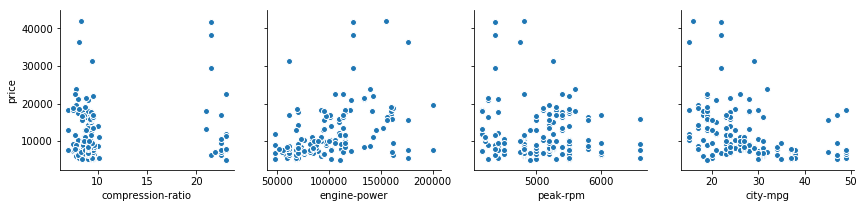

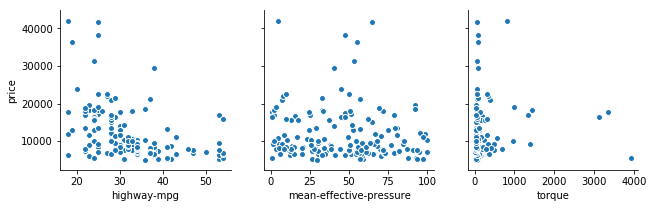

In [24]:
sns.pairplot(data=auto_numeric, x_vars=auto_numeric.drop('price', axis=1).columns[:4], y_vars = 'price', size=3)
sns.pairplot(data=auto_numeric, x_vars=auto_numeric.drop('price', axis=1).columns[4:8], y_vars = 'price', size=3)
sns.pairplot(data=auto_numeric, x_vars=auto_numeric.drop('price', axis=1).columns[8:12], y_vars = 'price', size=3)
sns.pairplot(data=auto_numeric, x_vars=auto_numeric.drop('price', axis=1).columns[12:], y_vars = 'price', size=3)
plt.show()

In [25]:
for column in auto_numeric.columns[:-1]:
    print("The CC for price and {} is {}".format(column,np.corrcoef(auto_numeric['price'],auto_numeric[column])[1,0]))

The CC for price and normalized-losses is 0.0153676474237
The CC for price and wheel-base is 0.42351059515
The CC for price and length is 0.512883045265
The CC for price and width is 0.524325552127
The CC for price and height is 0.139562558987
The CC for price and engine-size is 0.715124590191
The CC for price and bore is 0.365207289213
The CC for price and stroke is 0.127834031933
The CC for price and compression-ratio is 0.125683221675
The CC for price and engine-power is 0.443968591463
The CC for price and peak-rpm is -0.0993452910632
The CC for price and city-mpg is -0.356789500672
The CC for price and highway-mpg is -0.438467431714
The CC for price and mean-effective-pressure is -0.10486005065
The CC for price and torque is 0.101434581307


Two other attributes good for finding price are engine-size and width. By looking at the graphs to check obvious linearity and then confirming by checking the correlation coefficient.

Two attributes that might be useless are torque and compression ratio. I could have reported other attributes but this decision was based on both the graphs and CC. 

In the real world, I would also use subject specific knowledge, for example, it looks like torque is generally same for most vehicles, but I could have been more or less confident if I understood the automobile world. 

engine-size shows significant correlation with price and so does width and length. The graph of width and length look more linearly distributed, but the CC value for price and engine-size is higher.

We could safely remove the attributes which show least correlation and are generally known not to affect the price of a car in the industry. I'll be careful while removing attributes. But if I had to, torque and compression-ration mentioned above may be removed. 

### ========== Question 2.2 --- [3 marks] ==========
We will now make a first attempt at building a Multivariate Linear Regression model using all numeric attributes. Initialise a `LinearRegression` model and predict the output by using 5-fold cross-validation and the `cross_val_predict` function.

In [26]:
lr3 = LinearRegression()

predicted3 = cross_val_predict(lr2,auto_numeric.drop('price',axis=1),auto_numeric['price'],cv=kf)

### ========== Question 2.3 --- [2 marks] ==========
Display the Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and Correlation Coefficient (CC).

In [27]:
r2 = r2_score(auto_numeric['price'], predicted3)
rmse = np.sqrt(mean_squared_error(auto_numeric['price'], predicted3))
mae = mean_absolute_error(auto_numeric['price'], predicted3) 
coeff = np.corrcoef(auto_numeric['price'],predicted3)[0,1]
print("r2: {}\tRMSE: {}\tMAE: {}\tCC: {}".format(r2, rmse, mae, coeff))

r2: 0.486137984457	RMSE: 4819.80464284	MAE: 3050.34459963	CC: 0.742560270537


### ========== Question 2.4 --- [2 marks] ==========
 Comment on each metric display above in comparison to what you have obtained for the Simple Linear Regression model in Question 1.19.

It is clear that this model has performed better. RMSE and MAE are both lower in comparison and the CC has gone up.

### ========== Question 2.5 --- [2 marks] ==========
Examine the histogram for the `engine-size` attribute. Choose a sensible value for the number of bins in the histogram. Label axes appropriately and include a title in your plot.

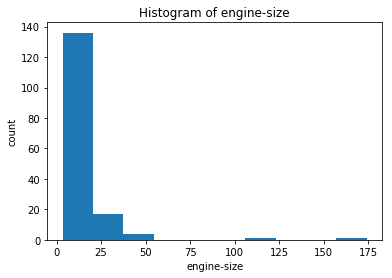

In [28]:
plt.hist(auto_numeric['engine-size'])
plt.xlabel('engine-size')
plt.ylabel('count')
plt.title('Histogram of engine-size')
plt.show()

### ========== Question 2.6 --- [2 marks] ==========
Is the distribution expected to cause a problem for regression? Explain your answer in 2-3 sentences.

The outliers shown above in the histogram (values greater than 100) should cause a probelm for regression as linear regression is very sensitive to outliers.

In Q2.1, I considered checking the graph of price and engine-size with the outliers removed, for the same reasons after it showed highest correlation. The graph isn't inclued in the final answer to Q2.1.

### ========== Question 2.7 --- [3 marks] ==========
Transform this attribute using an appropriate simple technique from the lectures. Plot the histogram of the transformed attribute.

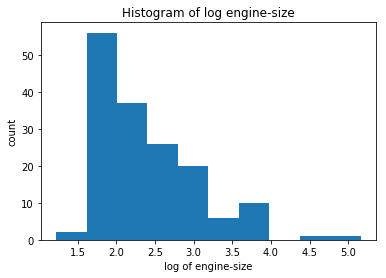

In [29]:
engineSize = auto_numeric['engine-size']
engineSize = np.log(engineSize)
plt.hist(engineSize)
plt.xlabel('log of engine-size')
plt.ylabel('count')
plt.title('Histogram of log engine-size')
plt.show()


In [30]:
auto_numeric['engine-size'] = engineSize

### ========== Question 2.8 --- [3 marks] ==========
Now re-build a Linear Regression model on the transformed dataset and report the R^2, RMSE, MAE and CC metrics.

In [31]:
lr4 = LinearRegression()
predicted4 = cross_val_predict(lr4,auto_numeric.drop('price',axis=1),auto_numeric['price'],cv=kf)

r2 = r2_score(auto_numeric['price'], predicted4)
rmse = np.sqrt(mean_squared_error(auto_numeric['price'], predicted4))
mae = mean_absolute_error(auto_numeric['price'], predicted4) 
coeff = np.corrcoef(auto_numeric['price'],predicted4)[0,1]
print("r2: {}\tRMSE: {}\tMAE: {}\tCC: {}".format(r2, rmse, mae, coeff))

r2: 0.689612268029	RMSE: 3745.91959756	MAE: 2668.36429567	CC: 0.831675321658


### ========== Question 2.9 --- [3 marks] ==========
How has the performance of your model changed? Explain your answer in 1-2 sentences.

The performance has clearly improved. Engine-size showed highest correlation with price in Q2.1 and transforming the attribute with log has had a big affect on the model.

### ========== Question 2.10 --- [2 marks] ==========
So far we have performed regression with numeric attributes. We will now attempt to integrate nominal (categorical) attributes into our regression model. 
Load the dataset `train_auto_full.csv` into a pandas DataFrame called `auto_full`. Display the number of samples and attributes in the dataset. Also, display the first 20 instances of the dataset. *Hint: Execute the cell below to change the default for `max_columns` display option in pandas.*

In [32]:
pd.set_option('max_columns', 30)

In [33]:
loc3 = os.path.join(os.getcwd(),'datasets','train_auto_full.csv')
auto_full = pd.read_csv(loc3)
print("The number of samples in dataset is {} and the number of attributes is {}".format(auto_full.shape[0],
                                                                                        auto_full.shape[1]))
auto_full.head(20)

The number of samples in dataset is 159 and the number of attributes is 27


,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,engine-power,peak-rpm,city-mpg,highway-mpg,symboling,mean-effective-pressure,torque,price
0,164.0,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,ohc,4,8.85,mpfi,3.19,3.40,10.00,102000.0,5500.0,24.0,30.0,2,40.52,57.68,13950.0
1,110.0,audi,gas,std,4,sedan,4wd,front,99.4,162.4,66.4,54.3,ohc,5,15.18,mpfi,3.19,3.40,8.00,115000.0,5500.0,18.0,22.0,2,47.39,59.59,17450.0
2,158.0,audi,gas,std,4,sedan,fwd,front,105.8,192.7,71.4,51.6,ohc,5,15.18,mpfi,3.94,2.80,8.50,70000.0,4400.0,28.0,30.0,1,0.85,3344.79,17710.0
3,106.0,audi,gas,turbo,4,sedan,fwd,front,86.6,158.7,67.7,55.9,ohc,5,13.74,mpfi,3.13,3.50,7.80,140000.0,5600.0,32.0,20.0,1,44.74,68.97,23875.0
4,192.0,bmw,gas,std,2,sedan,rwd,front,101.2,176.8,64.8,54.3,ohc,4,8.67,mpfi,3.50,2.80,8.80,101000.0,5800.0,23.0,29.0,2,44.78,53.48,16430.0
5,194.0,bmw,gas,std,4,sedan,rwd,front,110.0,190.9,71.4,58.7,ohc,4,8.67,mpfi,3.78,3.90,22.50,101000.0,6000.0,47.0,53.0,0,1.80,1330.28,16925.0
6,188.0,bmw,gas,std,2,sedan,rwd,front,101.2,176.8,64.8,54.3,ohc,6,26.58,mpfi,3.31,3.19,9.00,121000.0,4250.0,21.0,28.0,0,7.19,377.06,20970.0
7,150.0,bmw,gas,std,4,sedan,rwd,front,101.2,176.8,64.8,56.1,ohc,6,26.58,mpfi,3.03,3.19,8.00,134000.0,4400.0,28.0,37.0,0,57.37,48.20,21105.0
8,121.0,chevrolet,gas,std,2,hatchback,fwd,front,88.4,141.1,60.3,53.2,l,3,3.39,2bbl,3.03,3.03,9.50,48000.0,5300.0,47.0,53.0,2,59.33,25.08,5151.0
9,98.0,chevrolet,gas,std,2,hatchback,fwd,front,104.3,155.9,68.3,52.0,ohc,4,6.05,2bbl,3.31,3.47,7.80,70000.0,5000.0,34.0,34.0,1,51.55,36.35,6295.0


### ========== Question 2.11 --- [3 marks] ==========
This dataset contains a mixture of numeric and nominal attributes. Name the variables that you think are categorical. Why can we not use the nominal attributes in their current form for the purposes of regression? 

The categorical attributes are make, fuel-type, aspiration, num-of-doors, body-style, drive-wheels, engine-location, engine-type, num-of-cylinders, fuel-system, and symboling.

We can't use the categorical attributes as-is because regression considers all attributes to be numerical.

### ========== Question 2.12 --- [5 marks] ==========
Now we want to convert the categorical variables by using [One-Hot-Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). Familiarise yourself with the class. One limitation with this module is that it can deal only with categorical attributes in integer format (remember that in our example we have attributes in string format). 

Copy the `auto_full` dataframe into a new dataframe `auto_full_edit` and transform the categorical variables by using [Label Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Then transform again the categorical variables by using One-Hot-Encoding. Make sure you don't transform the continuous variables. *Hint: make appropriate use of the `categorical_features` parameter in [`OneHotEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder).*

Store the transformed attributes into a numpy array `X_enc` and display its dimensionality.  


In [62]:
asd = np.zeros((159,70),dtype=float)


In [69]:
auto_full_edit = auto_full.copy(deep=True)

categorical = []  # list to store indices of catgorical attributes 

# Any attribute which has less than 19 unique values is considered categorical.
# The number 19 was chosen after looking at the no. of unique values of all features.
for index, column in enumerate(auto_full_edit.columns):
    if np.unique(auto_full_edit[column]).size < 19:
        categorical.append(index)

# Use label encoder to change categorical attribute values into integer
for i in categorical:
    le = LabelEncoder()
    le.fit(auto_full_edit[auto_full_edit.columns[i]])   # fit column at location i
    auto_full_edit[auto_full_edit.columns[i]] = le.transform(auto_full_edit[auto_full_edit.columns[i]])
    
X_enc = auto_full_edit.drop('price',axis=1).as_matrix()
Y = auto_full_edit['price']

enc = OneHotEncoder(categorical_features=categorical)
X_enc = enc.fit_transform(X_enc)
print("The shape of X_enc is {}".format(X_enc.shape))

The shape of X_enc is (159, 70)


In [70]:
#X_enc2 = X_enc.toarray(out=asd)

### ========== Question 2.13 --- [2 marks] ==========
By using the transformed data train a multivariate linear regression model and by using 5-fold cross-validation report the R^2, RMSE, MAE and CC metrics.

In [71]:
lr5 = LinearRegression()
predicted5 = cross_val_predict(lr5, X_enc2, Y, cv=kf)

r2 = r2_score(y, predicted5)
rmse = np.sqrt(mean_squared_error(y, predicted5))
mae = mean_absolute_error(y, predicted5) 
coeff = np.corrcoef(y,predicted5)[0,1]
print("r2: {}\tRMSE: {}\tMAE: {}\tCC: {}".format(r2, rmse, mae, coeff))

r2: -7.63853089308e+12	RMSE: 18582797630.9	MAE: 2765275298.61	CC: -0.365468233408


### ========== Question 2.14 --- [4 marks] ==========
How does this more complex model perform with respect to your best performing model from either question 2.3 or 2.8? List one advantage and one disadvantage of using the more complex model.

This model performs better than both models in Q2.3 and Q2.8. Model in Q2.8 performed better than the one in Q2.3 after transforming the attribute which showed the highest correlation with price. This model is benifitted not only by the transformation but also the extra information the categorical attributes bring with them.

By using a complex model we can fit all the complexities/trends of the data into our model. However, we might end up overfitting the data using a complex model.

### ========== Question 2.15 --- [4 marks] ==========
Finally, experiment with tree-based regressors (e.g. [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)) and report 5-fold cross-validation scores for R^2, RMSE, MAE and CC. Has your performance improved? Explain your answer in 1-2 sentences.

In [ ]:
dt = DecisionTreeRegressor(random_state=0,max_depth=4)
predicted6 = cross_val_predict(dt, X_enc, Y, cv=kf)

rf = RandomForestRegressor(random_state=0)
predicted7 = cross_val_predict(rf, X_enc, Y, cv=kf)

print("Decison Tree Regressor")
r2 = r2_score(y, predicted6)
rmse = np.sqrt(mean_squared_error(y, predicted6))
mae = mean_absolute_error(y, predicted6) 
coeff = np.corrcoef(y,predicted6)[0,1]
print("r2: {}\tRMSE: {}\tMAE: {}\tCC: {}".format(r2, rmse, mae, coeff))

print("Random Forest Regressor")
r2 = r2_score(y, predicted7)
rmse = np.sqrt(mean_squared_error(y, predicted7))
mae = mean_absolute_error(y, predicted7) 
coeff = np.corrcoef(y,predicted7)[0,1]
print("r2: {}\tRMSE: {}\tMAE: {}\tCC: {}".format(r2, rmse, mae, coeff))

The performance is not better than the linear regressor. However, performance of random forest regressor is comparable to that of linear regression. 

Decision tree regressor performs as good as linear regression model in 2.8 and the random forest regressor performs better than the model in 2.8.

Experimented with values of n_estimators for random forest regressor with random_state fixed. 100 and 10 estimators gave similar result. Defaut value of 10 works fine.

Experimenting with depth. For random forest, depth of 4 gave a CC value of approx 0.91 which satyed constant for values greater than 4, i.e. 5 and 6. Letting the depth be default, as the result is similar. 
For, DT, max depth 4 gave the highest value of .89 while values below and above performed a little worse. Setting max_depth = 4 for DT.

